In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.price_history_18_seq2seq_raw_batch_norm import PriceHistorySeq2SeqRawBatchNorm

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [6]:
epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30

batch_size = 50 #47
#trunc_backprop_len = ??
with_EOS = False

In [7]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

### Once generate data

In [8]:
data_path = '../data/price_history'

In [9]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'

### Step 1 - collect data

In [10]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [11]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [12]:
model = PriceHistorySeq2SeqRawBatchNorm(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [13]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len)

60
Tensor("inputs/unstack:0", shape=(50, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(50, 400), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(50, 30), dtype=float32)


Tensor("error/Select:0", shape=(50, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)



In [14]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [15]:
#rnn_cell = PriceHistorySeq2SeqCV.RNN_CELLS.GRU
#cross_val_n_splits = 5
epochs, num_units, batch_size

(10, 400, 50)

In [16]:
#set(factors(train_size)).intersection(factors(train_size/5))

In [17]:
best_learning_rate = 1e-3 #0.0026945952539362472

In [18]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=10,
             batch_size = 50,
             num_units = 400,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled=True,
             #eos_token = float(1e3),
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

Attempt:  
Obviously performance is worse because when trying to get the system match normalized outputs with non normalized targets it will fail

learning rate: 0.001000  
epochs: 10  
End Epoch 01 (32.398 secs): err(train) = 4.630  
End Epoch 02 (31.190 secs): err(train) = 4.481  
End Epoch 03 (31.188 secs): err(train) = 4.390  
End Epoch 04 (31.200 secs): err(train) = 4.310  
End Epoch 05 (31.228 secs): err(train) = 4.240  
End Epoch 06 (31.251 secs): err(train) = 4.170  
End Epoch 07 (31.178 secs): err(train) = 4.101  
End Epoch 08 (31.235 secs): err(train) = 4.036  
End Epoch 09 (31.185 secs): err(train) = 3.984  
End Epoch 10 (31.154 secs): err(train) = 3.920  

All much larger than the 1.004 which is when it is overfitting

In [19]:
%%time
dyn_stats, preds_dict = get_or_run_nn(experiment,
                                      filename='018_seq2seq_60to30_epochs{}_learning_rate_{:.4f}'.format(
                                          epochs, best_learning_rate
                                      ))

learning rate: 0.001000
epochs: 10
End Epoch 01 (32.294 secs): err(train) = 1.777
End Epoch 02 (31.138 secs): err(train) = 1.204
End Epoch 03 (31.133 secs): err(train) = 1.117
End Epoch 04 (31.145 secs): err(train) = 1.073
End Epoch 05 (31.156 secs): err(train) = 1.049
End Epoch 06 (31.108 secs): err(train) = 1.034
End Epoch 07 (31.102 secs): err(train) = 1.033
End Epoch 08 (31.132 secs): err(train) = 1.013
End Epoch 09 (31.157 secs): err(train) = 1.007
End Epoch 10 (31.129 secs): err(train) = 1.004

CPU times: user 5min 36s, sys: 21.9 s, total: 5min 58s
Wall time: 5min 33s


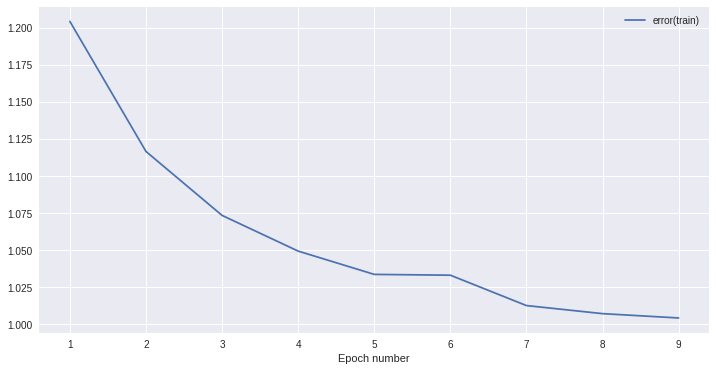

In [20]:
dyn_stats.plotStats()
plt.show()

In [21]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [30]:
ind = np.argmin(r2_scores)
ind

4398

In [22]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [23]:
r2_score(y_true=reals, y_pred=preds)

0.0

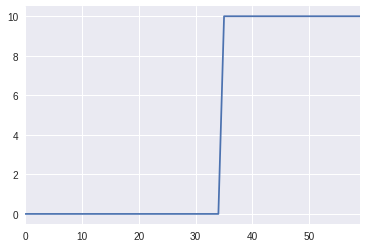

In [24]:
sns.tsplot(data=dp.inputs[ind].flatten())

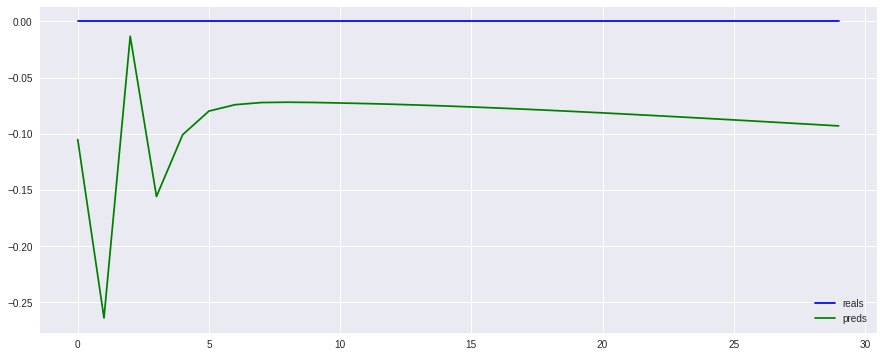

In [25]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [26]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 13 s, sys: 60 ms, total: 13 s
Wall time: 12.9 s


In [27]:
np.mean(dtw_scores)

8.9385718451794691

In [28]:
coint(preds, reals)

(-2.0103289088173533,
 0.52320489914792923,
 array([-4.31395736, -3.55493606, -3.19393252]))

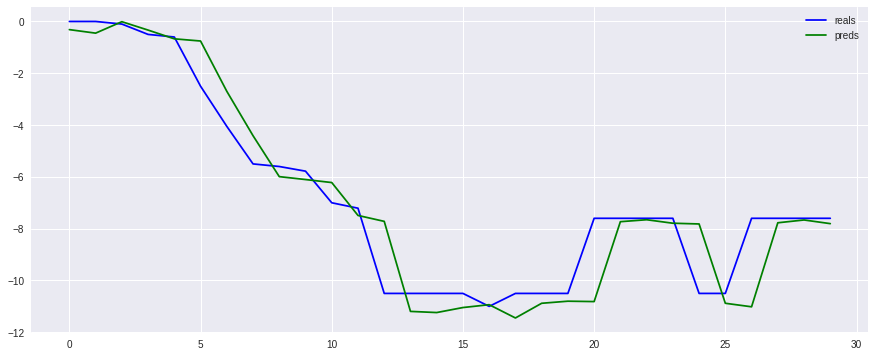

In [33]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???